FINAL CODE

In [1]:
!pip install memory_profiler
!pip install seaborn

import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import memory_profiler
from memory_profiler import memory_usage
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

##########################################################################PROXIMITY OPERATORS################################################

def soft_threshold(x, lambda_val):
    return np.sign(x) * np.maximum(np.abs(x) - lambda_val, 0)

def elastic_net_prox(x, lambda_l1, lambda_l2, L):
    return soft_threshold(x, lambda_l1 / L) / (1 + lambda_l2 / L)

def ridge_prox(x, lambda_l2, L):
    return x / (1 + lambda_l2 / L)

## Function to choose the right proximal operator in each case
def prox_operator(x, regularization_type, lambda_l1, lambda_l2, L):
    if regularization_type == 'l1':
        return soft_threshold(x, lambda_l1 / L)
    elif regularization_type == 'l2':
        return ridge_prox(x, lambda_l2, L)
    elif regularization_type == 'elastic_net':
        return elastic_net_prox(x, lambda_l1, lambda_l2, L)
    else:
        raise ValueError(f"Unknown regularization type: {regularization_type}")

######################################################LINE SEARCH METHODS###########################################################
def determine_reg_type(lambda_l1,lambda_l2):
     if lambda_l1 > 0 and lambda_l2 > 0:
        return 'elastic_net'
     elif lambda_l1 > 0:
        return 'l1'
     elif lambda_l2 > 0:
        return 'l2'

## Objective function

def objective_function(A, b, x, lambda_l1=0.0, lambda_l2=0.0, regularization_type='l1'):
    f_x = 0.5 * np.sum((A @ x - b) ** 2)
    if regularization_type == 'l1':
        g_x = lambda_l1 * np.sum(np.abs(x))
    elif regularization_type == 'l2':
        g_x = 0.5*lambda_l2 * np.sum(x ** 2)
    elif regularization_type == 'elastic_net':
        g_x = lambda_l1 * np.sum(np.abs(x)) + 0.5*lambda_l2 * np.sum(x ** 2)
    else:
        raise ValueError(f"Unknown regularization type: {regularization_type}")
    return f_x + g_x

def backtracking_line_search(A, b, x, grad, lambda_l1, lambda_l2, regularization_type, alpha=0.5, beta=0.8, max_iter=100):
    t = 1.0
    f_x = objective_function(A, b, x, lambda_l1, lambda_l2, regularization_type)
    grad_norm_sq = np.sum(grad ** 2)

    for _ in range(max_iter):
        x_new = prox_operator(x - t * grad, regularization_type, lambda_l1, lambda_l2, 1/t)
        f_x_new = objective_function(A, b, x_new, lambda_l1, lambda_l2, regularization_type)
        if f_x_new <= f_x - alpha * t * grad_norm_sq:
            return t
        t *= beta
    return t

############################################################ALGORITHMS###############################################################
## The way these functions are designed is explained in detail in the project report

def ista(A, b, lambda_l1, lambda_l2=0.0, max_iter=1000, tol=1e-6, return_iterations=False, regularization_type='elastic_net', line_search='fixed'):
    n_samples, n_features = A.shape
    x = np.zeros(n_features)
    if line_search == 'fixed':
      L = np.linalg.norm(A.T @ A, 2) + 2 * lambda_l2
    mse_history = []
    f_x_history=[]
    for k in range(max_iter):
        grad = A.T @ (A @ x - b) + 2 * lambda_l2 * x
        if line_search == 'fixed':
            x_new = prox_operator(x - grad / L, regularization_type, lambda_l1, lambda_l2, L)
        elif line_search == 'backtracking':
            t = backtracking_line_search(A, b, x, grad, lambda_l1, lambda_l2, regularization_type)
            x_new = prox_operator(x - t * grad, regularization_type, lambda_l1, lambda_l2, 1/t)
        else:
            raise ValueError(f"Unknown line search method: {line_search}")
        if k % 10 == 0 or k == max_iter - 1:
          if return_iterations:
           mse = np.mean((A @ x_new - b) ** 2)
           f_x = objective_function(A, b, x_new, lambda_l1, lambda_l2, regularization_type)
           mse_history.append(mse)
           f_x_history.append(f_x)
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new

    if return_iterations:
        return x, k, mse_history, f_x_history
    return x

def fista(A, b, lambda_l1, lambda_l2=0.0, max_iter=1000, tol=1e-6, return_iterations=False, regularization_type='elastic_net', line_search='fixed'):
    n_samples, n_features = A.shape
    x = np.zeros(n_features)
    y = x.copy()
    t = 1
    if line_search == 'fixed':
     L = np.linalg.norm(A.T @ A, 2) + 2 * lambda_l2
    mse_history = []
    f_x_history=[]
    for k in range(max_iter):
        grad = A.T @ (A @ y - b) + 2 * lambda_l2 * y

        if line_search == 'fixed':
            x_new = prox_operator(y - grad / L, regularization_type, lambda_l1, lambda_l2, L)
        elif line_search == 'backtracking':
            t_step = backtracking_line_search(A, b, y, grad, lambda_l1, lambda_l2, regularization_type)
            x_new = prox_operator(y - t_step * grad, regularization_type, lambda_l1, lambda_l2, 1/t_step)
        else:
            raise ValueError(f"Unknown line search method: {line_search}")

        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y = x_new + ((t - 1) / t_new) * (x_new - x)
        if k % 10 == 0 or k == max_iter - 1:
          if return_iterations:
           mse = np.mean((A @ x_new - b) ** 2)
           mse_history.append(mse)
           f_x = objective_function(A, b, x_new, lambda_l1, lambda_l2, regularization_type)
           f_x_history.append(f_x)
        if np.linalg.norm(x_new - x) < tol:
            break

        x, t = x_new, t_new

    if return_iterations:
        return x, k, mse_history, f_x_history
    return x


def gradient_descent(A, b, lambda_l2=0.0, max_iter=1000, tol=1e-6, return_iterations=True, line_search='fixed'):
    n_features = A.shape[1]
    x = np.zeros(n_features)
    mse_history = []
    f_x_history=[]
    if line_search == 'fixed':
        L = np.linalg.norm(A.T @ A, 2) + 2 * lambda_l2
        lr = 1 / L

    for k in range(int(max_iter)):
        grad = A.T @ (A @ x - b) + 2 * lambda_l2 * x

        if line_search == 'fixed':
            x_new = x - lr * grad
        elif line_search == 'backtracking':
            t = backtracking_line_search(A, b, x, grad, 0.0, lambda_l2, 'l2')
            x_new = x - t * grad
        else:
            raise ValueError(f"Unknown line search method: {line_search}")
        if k % 10 == 0 or k == max_iter - 1 :
          if return_iterations:
           mse = np.mean((A @ x_new - b) ** 2)
           mse_history.append(mse)
           f_x = objective_function(A, b, x_new,lambda_l2,0, regularization_type=determine_reg_type(0,lambda_l2))
           f_x_history.append(f_x)
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new

    if return_iterations:
        return x, k, mse_history, f_x_history
    return x

def dual_fista(A, b, lambda_l1, max_iter=1000, tol=1e-6, return_iterations=False):
    """
    Dual-FISTA solver for LASSO problems (ℓ₁ only).

    Solves:
        min_x 0.5 * ||Ax - b||^2 + lambda_l1 * ||x||_1

    by solving its dual:
        max_alpha -0.5 * ||alpha||^2 - b^T alpha
        subject to ||A^T alpha||_∞ ≤ lambda_l1

    Parameters:
        A : ndarray, shape (n_samples, n_features)
        b : ndarray, shape (n_samples,)
        lambda_l1 : regularization parameter (ℓ₁)
        max_iter : maximum number of iterations
        tol : convergence tolerance
        return_iterations : if True, returns diagnostics

    Returns:
        x : primal solution
        (optionally: k, mse_history, f_x_history)
    """
    n_samples, _ = A.shape
    alpha = np.zeros(n_samples)
    y = alpha.copy()
    t = 1.0
    L = np.linalg.norm(A @ A.T, 2)
    mse_history = []
    f_x_history = []

    for k in range(max_iter):
        grad = A @ (A.T @ y) - b
        alpha_new = y - grad / L

        # Project onto dual feasible set: ||Aᵗ alpha||_∞ ≤ lambda₁
        AT_alpha = A.T @ alpha_new
        scaling = max(1.0, np.max(np.abs(AT_alpha)) / lambda_l1)
        alpha_new /= scaling

        # FISTA update
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y = alpha_new + ((t - 1) / t_new) * (alpha_new - alpha)
        alpha = alpha_new
        t = t_new
        x_est = A.T @ alpha
        # Primal estimate
        if k % 10 == 0 or k == max_iter - 1:
          if return_iterations:
            mse = np.mean((A @ x_est - b) ** 2)
            mse_history.append(mse)

            # Objective
            f_x = 0.5 * np.linalg.norm(A @ x_est - b) ** 2 + lambda_l1 * np.linalg.norm(x_est, 1)
            f_x_history.append(f_x)

        if np.linalg.norm(grad) < tol:
            break

    if return_iterations:
        return x_est, k, mse_history, f_x_history
    return x_est


Creation of synthetic datasets

In [2]:
# Synthetic data generation for testing purposes
def generate_data(n_samples=200, n_features=50, sparsity=0.1, noise_level=0.1):
    np.random.seed(42)
    A = np.random.randn(n_samples, n_features)
    x_true = np.zeros(n_features)
    n_nonzero = int(sparsity * n_features)
    nonzero_indices = np.random.choice(n_features, n_nonzero, replace=False)
    x_true[nonzero_indices] = np.random.randn(n_nonzero)
    b = A @ x_true + noise_level * np.random.randn(n_samples)
    return A, b, x_true

This benchmarking functions enables us to solve the regression problem for each algortihm, for a wide range of parameters lambda_l1, lambda_l2, max iter, tolerance ....

We then get as an outpout a dataframe containing the average of the n_runs from each algorithm of most of the essential performace measures. It also gives us the value of the MSE and the objective function at each step during each run.

It can be run on synthetic datasets to observe if the expected behavior is followed or on real datasets to make sure the theoritical promises are fufilled.

In [3]:
######################################################## BENCHMARKING ##############################################################

def run_benchmark(algorithms, data_configs, lambda_range_l1, lambda_range_l2=None, max_iter=1000, tol=1e-3,
                  return_iterations=True, line_search='fixed', n_runs=1,
                  real_datasets=None, target_cols=None):
    if lambda_range_l2 is None:
        lambda_range_l2 = [0.0]
    results = []
    records = []
    # Takes the real dataset and extracts the target column, the splits the samples into training and testing to
    # Make sure our algorithm finds a suitable solution
    if real_datasets:
        if target_cols is None:
            raise ValueError("target_cols must be specified when using real_datasets.")
        dataset_iter = []
        for name, df in real_datasets.items():
            if name not in target_cols:
                raise ValueError(f"Missing target column for dataset '{name}' in target_cols.")
            target_col = target_cols[name]
            A = df.drop(columns=[target_col]).values
            b = np.log1p(df[target_col].values)  # log transform
            A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.2, random_state=42)
            scaler_y = MinMaxScaler()
            b_train = scaler_y.fit_transform(b_train.reshape(-1, 1)).ravel()
            b_test  = scaler_y.transform(b_test.reshape(-1, 1)).ravel()
            dataset_iter.append((name, A_train, b_train, A_test, b_test, None))
    else:
        dataset_iter = []
        for i, config in enumerate(data_configs):
            A, b, x_true = generate_data(**config)
            dataset_iter.append((f"synthetic_{i}", A, b, None, None, x_true))

    for dataset in dataset_iter:
        dataset_name, A, b, A_test, b_test, x_true = dataset

        for lambda_l1 in lambda_range_l1:
            for lambda_l2 in lambda_range_l2:
                reg_type = 'elastic_net' if lambda_l1 > 0 and lambda_l2 > 0 else 'l1' if lambda_l1 > 0 else 'l2'
                for algo_name in algorithms:
                    algo_func = globals()[algo_name]
                    exec_times = []
                    iterations = []
                    memories = []
                    solutions = []
                    last_mse_hist = []

                    for _ in range(n_runs):
                        start_time = time.time()

                        if algo_name in ['ista', 'fista']:
                            mem_usage = memory_usage((algo_func, (A, b, lambda_l1), {
                                'lambda_l2': lambda_l2,
                                'max_iter': max_iter,
                                'tol': tol,
                                'return_iterations': return_iterations,
                                'regularization_type': reg_type,
                                'line_search': line_search
                            }), interval=0.1, timeout=1)
                            x, iters, mse_hist ,f_x_hist = algo_func(A, b, lambda_l1, lambda_l2, max_iter, tol,
                                                          return_iterations, reg_type, line_search)
                        elif algo_name == 'dual_fista':
                            mem_usage = memory_usage((algo_func, (A, b, lambda_l1), {
                                'max_iter': max_iter,
                                'tol': tol,
                                'return_iterations': return_iterations
                            }), interval=0.1, timeout=1)
                            x, iters, mse_hist, f_x_hist = algo_func(A, b, lambda_l1, max_iter, tol,
                                                          return_iterations)
                        elif algo_name == 'gradient_descent':
                            mem_usage = memory_usage((algo_func, (A, b), {
                                'lambda_l2': lambda_l2,
                                'max_iter': max_iter,
                                'tol': tol,
                                'return_iterations': return_iterations,
                                'line_search': line_search
                            }), interval=0.1, timeout=1)
                            x, iters, mse_hist, f_x_hist = algo_func(A, b, lambda_l2=lambda_l2, max_iter=max_iter,
                                                          tol=tol, return_iterations=return_iterations,
                                                          line_search=line_search)
                        else:
                            mem_usage = memory_usage((algo_func, (A, b, lambda_l1, lambda_l2), {
                                'return_iterations': return_iterations
                            }), interval=0.1, timeout=1)
                            x, iters = algo_func(A, b, lambda_l1, lambda_l2, return_iterations)
                            mse_hist = []

                        end_time = time.time()
                        exec_times.append(end_time - start_time)
                        iterations.append(iters)
                        memories.append(max(mem_usage))
                        solutions.append(x)
                        last_mse_hist = mse_hist
                        last_fx_hist= f_x_hist

                    avg_solution = np.mean(solutions, axis=0)
                    mse_train = np.mean((A @ avg_solution - b) ** 2)
                    mse_test = np.mean((A_test @ avg_solution - b_test) ** 2) if A_test is not None else np.nan
                    sparsity = np.mean(np.abs(avg_solution) < tol)
                    error_to_true = np.nan
                    if real_datasets is None:
                        error_to_true = np.linalg.norm(avg_solution - x_true)

                    results.append({
                        'dataset': dataset_name,
                        'algorithm': algo_name,
                        'lambda_l1': lambda_l1,
                        'lambda_l2': lambda_l2,
                        'n_samples': A.shape[0],
                        'n_features': A.shape[1],
                        'sparsity': sparsity,
                        'avg_time': np.mean(exec_times),
                        'std_time': np.std(exec_times),
                        'min_time': np.min(exec_times),
                        'max_time': np.max(exec_times),
                        'max_iterations': np.nanmax(iterations),
                        'min_iterations': np.nanmin(iterations),
                        'avg_iterations': np.nanmean(iterations),
                        'std_iterations': np.nanstd(iterations),
                        'avg_memory': np.mean(memories),
                        'mse_train': mse_train,
                        'mse_test': mse_test,
                        'solution_sparsity': sparsity,
                        'error_to_true': error_to_true
                    })

                    if last_mse_hist:
                        records.append({ 'algorithm': algo_name,
                                              'dataset': dataset_name,
                                             'lambda_l1': lambda_l1,
                                             'lambda_l2': lambda_l2,
                                             'mse_history': last_mse_hist,
                                             'f_x_history': last_fx_hist
                                      })

    return pd.DataFrame(results), records

We used google colab for the project so the datatsets were stored in the Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Here we import the 2 datasets and define the target columns.

These datasets have already been preprocessed for the most part. Except the value of of the Sale prices for the House prices dataset were we applied a log function to make their values more manageable.

In [5]:
real_datasets = {
    "house_prices": pd.read_csv("/content/drive/MyDrive/house_prices_preprocessed.csv"),
    "house_prices2": pd.read_csv("/content/drive/MyDrive/house2_prices_preprocessed.csv"),
    "Student_grades" : pd.read_csv("/content/drive/MyDrive/students_normalized2.csv")
}
target_cols = {
    "house_prices": "SalePrice",
    "house_prices2": "median_house_value",
    "Student_grades" : "math score"
}


Glimpse of the different datsets; the design matrix of each dataset is very different in number of features (288 vs 14). And the values of said features are also very different with the Student Grades matrix being quite sparse.

In [6]:
real_datasets["house_prices"].head(5)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,0.131067,-0.237456,-0.333244,0.652644,-0.564161,1.053246,0.878668,0.795643,0.614224,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,208500
1,-0.935733,0.633321,-0.013189,-0.073068,2.030907,0.156179,-0.429577,-0.667353,1.242296,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,181500
2,0.131067,-0.063300,0.446022,0.652644,-0.564161,0.986797,0.830215,0.541858,0.106224,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,223500
3,0.397766,-0.527714,-0.027104,0.652644,-0.564161,-1.870528,-0.720298,-0.667353,-0.517230,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,140000
4,0.131067,0.865528,1.283733,1.378355,-0.564161,0.953572,0.733308,1.945140,0.496460,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,250000


In [7]:
real_datasets["house_prices2"].head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,median_house_value
0,-1.327835,1.052548,0.982143,-1.117285,-1.309916,-1.325821,-1.291972,2.541006,0.0,0.0,0.0,1.0,0.0,452600.0
1,-1.322844,1.043185,-0.607019,2.329936,2.128690,1.389936,2.348314,2.541006,0.0,0.0,0.0,1.0,0.0,358500.0
2,-1.332827,1.038503,1.856182,-0.697327,-1.095223,-1.098528,-1.099883,2.085156,0.0,0.0,0.0,1.0,0.0,352100.0
3,-1.337818,1.038503,1.856182,-0.835405,-0.936843,-1.017539,-0.941691,1.111288,0.0,0.0,0.0,1.0,0.0,341300.0
4,-1.337818,1.038503,1.856182,-0.582857,-0.778463,-1.008395,-0.791033,0.027262,0.0,0.0,0.0,1.0,0.0,342200.0


In [8]:
real_datasets["Student_grades"].head(5)

,reading score,writing score,gender_male,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_standard,test preparation course_none,math score
0,0.662651,0.711111,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.72
1,0.879518,0.866667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.69
2,0.939759,0.922222,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.90
3,0.481928,0.377778,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.47
4,0.734940,0.722222,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.76


In [9]:
def get_best_hyperparams(results_df, metric="mse_test"):
    """
    Extract the best (lambda_l1, lambda_l2) combination for each algorithm and dataset
    based on the lowest mse_test (or another metric).

    Parameters:
    - results_df: DataFrame returned by run_benchmark
    - metric: the metric to minimize (default: mse_test)

    Returns:
    - DataFrame with one row per (algorithm, dataset) with the best hyperparameters
    """
    # Filter out NaNs just in case
    filtered_df = results_df.dropna(subset=[metric])

    # Group by algorithm and dataset, select the row with minimal metric value
    best_params = (
        filtered_df.loc[filtered_df.groupby(["algorithm", "dataset"])[metric].idxmin()]
        .reset_index(drop=True)
        .sort_values(by=["dataset", "algorithm"])
    )

    return best_params


  This is the grid in which we will be looking for the best pair of lamabda_l1 and lambda_l2 for each algorithm.


  This is essential to give a fair shot to each algorithm on each dataset, if we do not complete this step and compared the algorithms for the same parameters then we would just see which algorithm is best for each set of parameters and not the one who is truly superior in a real life application.

In [10]:
range_l1= [10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 1]
range_l2= [10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 1]

In [11]:
results_ista, records_ista = run_benchmark(
    algorithms=['ista'],
    data_configs=[],  # real dataset so empty
    lambda_range_l1=range_l1,
    lambda_range_l2=range_l2,
    real_datasets=real_datasets,
    target_cols=target_cols,
    max_iter=1000,
    tol=1e-5,
    return_iterations=True,
    line_search='fixed',
    n_runs=3
)
best_params_ista = get_best_hyperparams(results_ista)
print(best_params_ista)

          dataset algorithm  lambda_l1  lambda_l2  n_samples  n_features  \
0  Student_grades      ista     1.0000     0.0001        800          14   
1    house_prices      ista     0.0001     1.0000       1168         287   
2   house_prices2      ista     1.0000     0.0001      16512          13   

   sparsity  avg_time  std_time  min_time  max_time  max_iterations  \
0  0.285714  0.149512  0.001355  0.147830  0.151148             999   
1  0.041812  1.088628  0.104852  1.008769  1.236761             999   
2  0.000000  0.745400  0.008724  0.734577  0.755940             999   

   min_iterations  avg_iterations  std_iterations  avg_memory  mse_train  \
0             999           999.0             0.0  258.380208   0.002966   
1             999           999.0             0.0  257.576823   0.001250   
2             999           999.0             0.0  258.071615   0.007908   

   mse_test  solution_sparsity  error_to_true  
0  0.003071           0.285714            NaN  
1  0.0017

In [12]:
results_fista, records_fista = run_benchmark(
    algorithms=['fista'],
    data_configs=[],  # real datasets so empty
    lambda_range_l1=range_l1,
    lambda_range_l2=range_l2,
    real_datasets=real_datasets,
    target_cols=target_cols,
    max_iter=1000,
    tol=1e-5,
    return_iterations=True,
    line_search='fixed',
    n_runs=3
)
best_params_fista = get_best_hyperparams(results_fista)
print(best_params_fista)

          dataset algorithm  lambda_l1  lambda_l2  n_samples  n_features  \
0  Student_grades     fista        1.0     0.1000        800          14   
1    house_prices     fista        0.1     0.0100       1168         287   
2   house_prices2     fista        0.1     0.0001      16512          13   

   sparsity  avg_time  std_time  min_time  max_time  max_iterations  \
0  0.285714  0.120452  0.001159  0.119276  0.122028             192   
1  0.466899  0.706052  0.024349  0.677627  0.737098             999   
2  0.000000  0.500961  0.002885  0.498602  0.505024             648   

   min_iterations  avg_iterations  std_iterations  avg_memory  mse_train  \
0             192           192.0             0.0  261.707031   0.002900   
1             999           999.0             0.0  261.226562   0.001032   
2             648           648.0             0.0  261.453125   0.007740   

   mse_test  solution_sparsity  error_to_true  
0  0.003076           0.285714            NaN  
1  0.0016

In [13]:
results_GD, records__GD = run_benchmark(
    algorithms=['gradient_descent'],
    data_configs=[],  # real datasets so empty
    lambda_range_l1=[0],
    lambda_range_l2=range_l2,
    real_datasets=real_datasets,
    target_cols=target_cols,
    max_iter=1000,
    tol=1e-5,
    return_iterations=True,
    line_search='fixed',
    n_runs=3
)
best_params_GD = get_best_hyperparams(results_GD)
print(best_params_GD)

          dataset         algorithm  lambda_l1  lambda_l2  n_samples  \
0  Student_grades  gradient_descent          0     0.0001        800   
1    house_prices  gradient_descent          0     1.0000       1168   
2   house_prices2  gradient_descent          0     0.0001      16512   

   n_features  sparsity  avg_time  std_time  min_time  max_time  \
0          14  0.000000  0.143409  0.007481  0.137119  0.153921   
1         287  0.041812  0.669877  0.026766  0.635428  0.700688   
2          13  0.000000  0.754181  0.013506  0.738838  0.771703   

   max_iterations  min_iterations  avg_iterations  std_iterations  avg_memory  \
0             999             999           999.0             0.0  262.139323   
1             999             999           999.0             0.0  262.078125   
2             999             999           999.0             0.0  262.075521   

   mse_train  mse_test  solution_sparsity  error_to_true  
0   0.002920  0.003083           0.000000            NaN  

We cannot execute dual_fista with a huge number of samples, indeed the dual vector alpha has a size of about 20000 in the house_price2 case.

In [14]:
filtered_real_datasets = {k: v for k, v in real_datasets.items() if k != "house_prices2"}
filtered_target_cols = {k: v for k, v in target_cols.items() if k != "house_prices2"}

# Then run benchmark
results_dual, records_dual = run_benchmark(
    algorithms=['dual_fista'],
    data_configs=[],
    lambda_range_l1=range_l1,
    lambda_range_l2=[0],
    real_datasets=filtered_real_datasets,
    target_cols=filtered_target_cols,
    max_iter=1000,
    tol=1e-5,
    return_iterations=True,
    line_search='fixed',
    n_runs=3
)
best_params_dual = get_best_hyperparams(results_dual)
print(best_params_dual)

          dataset   algorithm  lambda_l1  lambda_l2  n_samples  n_features  \
0  Student_grades  dual_fista        1.0          0        800          14   
1    house_prices  dual_fista        0.1          0       1168         287   

   sparsity  avg_time  std_time  min_time  max_time  max_iterations  \
0  0.000000  3.529462  1.234160  2.650111  5.274811             999   
1  0.041812  3.835933  1.848035  2.508395  6.449339             999   

   min_iterations  avg_iterations  std_iterations  avg_memory  mse_train  \
0             999           999.0             0.0  271.605469   0.002846   
1             999           999.0             0.0  282.605469   0.000982   

   mse_test  solution_sparsity  error_to_true  
0  0.003120           0.000000            NaN  
1  0.001704           0.041812            NaN  


Combining the best parameters and the value of the performance indicators for each algorithm

In [15]:
def merge_best_param_tables(*tables):
    """
    Concatenate multiple best_param DataFrames into a single combined DataFrame.

    Parameters:
    - *tables: any number of DataFrames to merge

    Returns:
    - A single concatenated DataFrame
    """
    merged_df = pd.concat(tables, axis=0, ignore_index=True)
    return merged_df

combined_best = merge_best_param_tables(best_params_ista, best_params_fista, best_params_dual, best_params_GD)
print(combined_best)


           dataset         algorithm  lambda_l1  lambda_l2  n_samples  \
0   Student_grades              ista     1.0000     0.0001        800   
1     house_prices              ista     0.0001     1.0000       1168   
2    house_prices2              ista     1.0000     0.0001      16512   
3   Student_grades             fista     1.0000     0.1000        800   
4     house_prices             fista     0.1000     0.0100       1168   
5    house_prices2             fista     0.1000     0.0001      16512   
6   Student_grades        dual_fista     1.0000     0.0000        800   
7     house_prices        dual_fista     0.1000     0.0000       1168   
8   Student_grades  gradient_descent     0.0000     0.0001        800   
9     house_prices  gradient_descent     0.0000     1.0000       1168   
10   house_prices2  gradient_descent     0.0000     0.0001      16512   

    n_features  sparsity  avg_time  std_time  min_time  max_time  \
0           14  0.285714  0.149512  0.001355  0.147830 

Combining the different records to be able to plot them afterwards

In [16]:
def flatten_record_lists(*record_lists):
    """
    Flatten multiple lists of benchmark records into a single list.

    Parameters:
    - *record_lists: one or more lists of benchmark records (dicts)

    Returns:
    - A single flat list combining all records
    """
    flat_records = []
    for record_list in record_lists:
        flat_records.extend(record_list)
    return flat_records
combined_records = flatten_record_lists(records_ista, records_fista, records_dual, records__GD)
print(combined_records)

[{'algorithm': 'ista', 'dataset': 'house_prices', 'lambda_l1': 0.0001, 'lambda_l2': 0.0001, 'mse_history': [np.float64(0.009810304256049871), np.float64(0.0027824684235157587), np.float64(0.002362424797832214), np.float64(0.0021543437561289294), np.float64(0.0020276652617344563), np.float64(0.0019407325424387163), np.float64(0.0018758861330930923), np.float64(0.0018245985292193365), np.float64(0.0017823480911897914), np.float64(0.0017465311542853848), np.float64(0.0017155312184436162), np.float64(0.0016882768004127325), np.float64(0.0016640185379840375), np.float64(0.0016422101063782706), np.float64(0.0016224401544837873), np.float64(0.0016043912344533646), np.float64(0.0015878134281613982), np.float64(0.001572506799501151), np.float64(0.001558309082114131), np.float64(0.0015450869388075423), np.float64(0.0015327296177712114), np.float64(0.0015211441746259523), np.float64(0.0015102518665058395), np.float64(0.0014999853765131496), np.float64(0.0014902867286624), np.float64(0.00148110556

Function to plot the MSE of each algorithm as a function of iterations, we use the best hyperparameters for each algorithm of course.


In [41]:
def plot_best_mse(records, best_params_df, dataset_name):
    """
    Plot MSE vs Iteration for all algorithms on the same dataset using their best hyperparameters.

    Parameters:
    - records: list of benchmark record dicts
    - best_params_df: DataFrame containing best parameters for each (algorithm, dataset)
    - dataset_name: name of the dataset to filter
    """
    plt.figure(figsize=(10, 6))
    found_any = False

    for _, row in best_params_df.iterrows():
        if row['dataset'] != dataset_name:
            continue

        algo = row['algorithm']
        l1 = row['lambda_l1']
        l2 = row['lambda_l2']

        for rec in records:
            if (rec['dataset'] == dataset_name and rec['algorithm'] == algo and
                rec['lambda_l1'] == l1 and rec['lambda_l2'] == l2):
                plt.plot(rec['mse_history'], label=f"{algo} (λ₁={l1}, λ₂={l2})")
                found_any = True
                break

    if found_any:
        plt.title(f"MSE vs Iterations for All Algorithms on {dataset_name}")
        plt.xlabel("Iterations (divided by 10)")
        plt.ylabel("MSE")
        plt.yscale('log')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No records found for dataset: {dataset_name}")

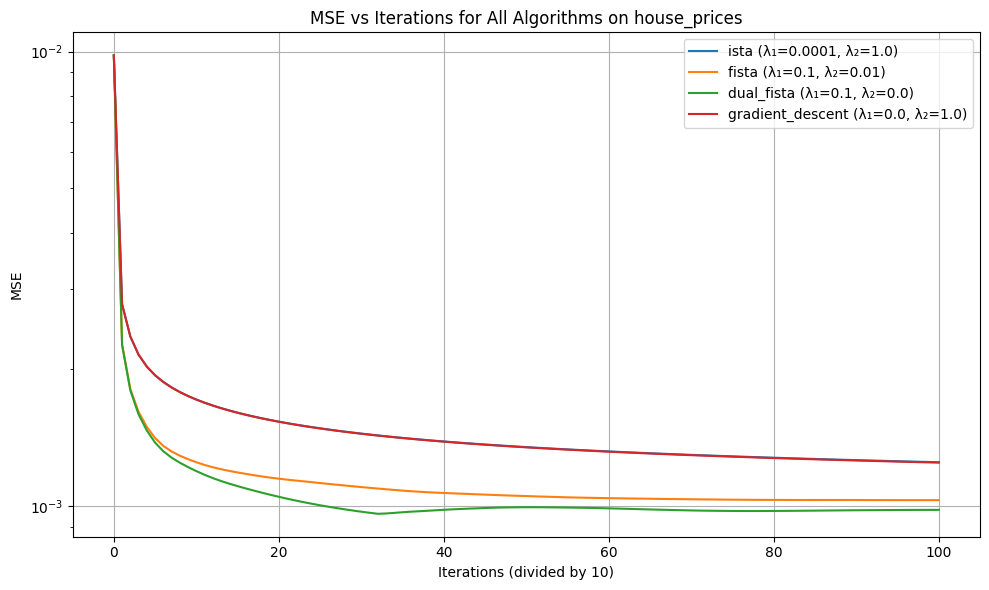

In [42]:
plot_best_mse(combined_records, combined_best, "house_prices")

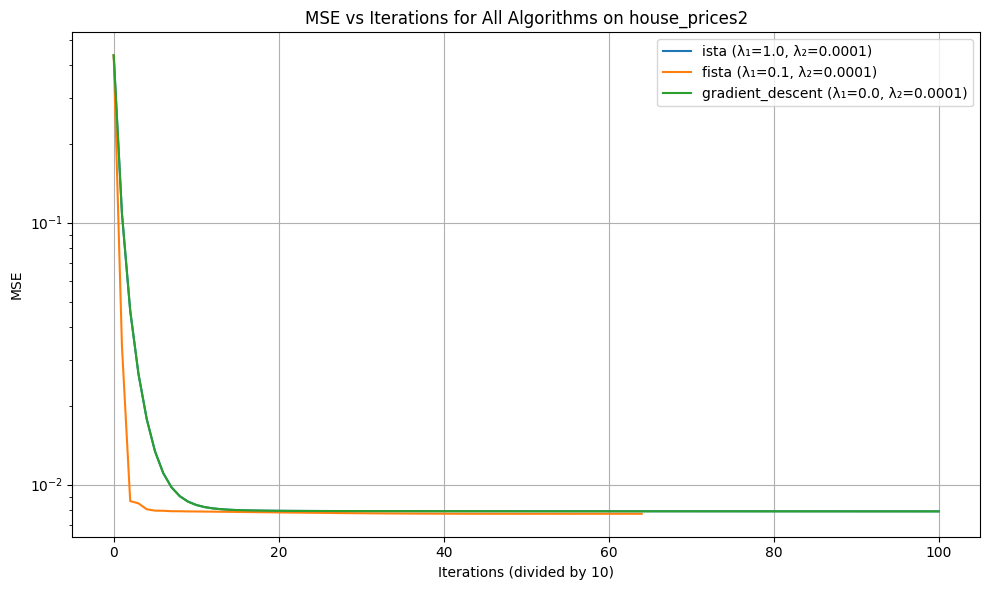

In [43]:
plot_best_mse(combined_records, combined_best, "house_prices2")

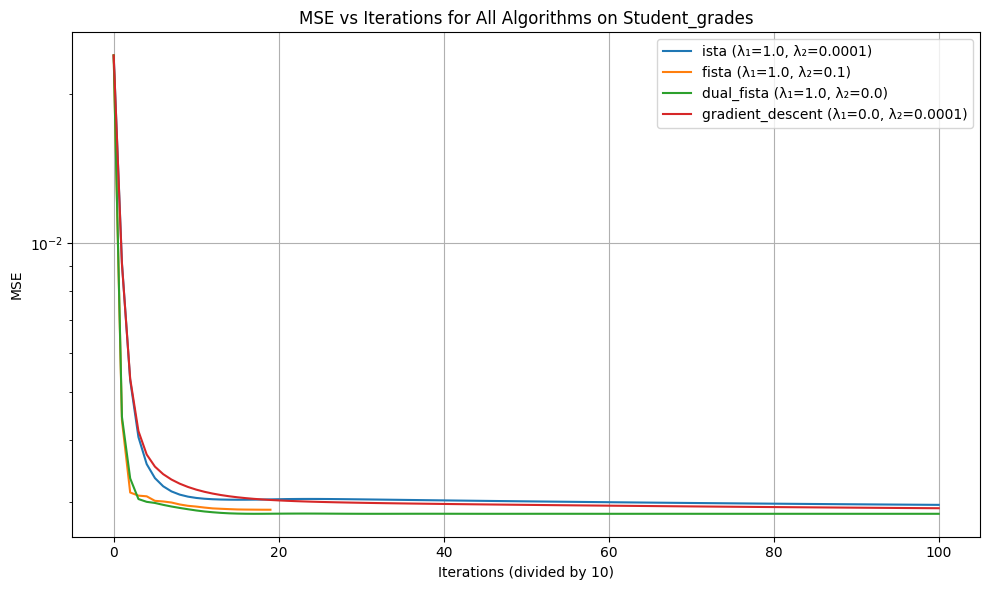

In [44]:
plot_best_mse(combined_records, combined_best, "Student_grades")

Function to plot the evolution of the objective function for each algorithm at the best hyperparameters

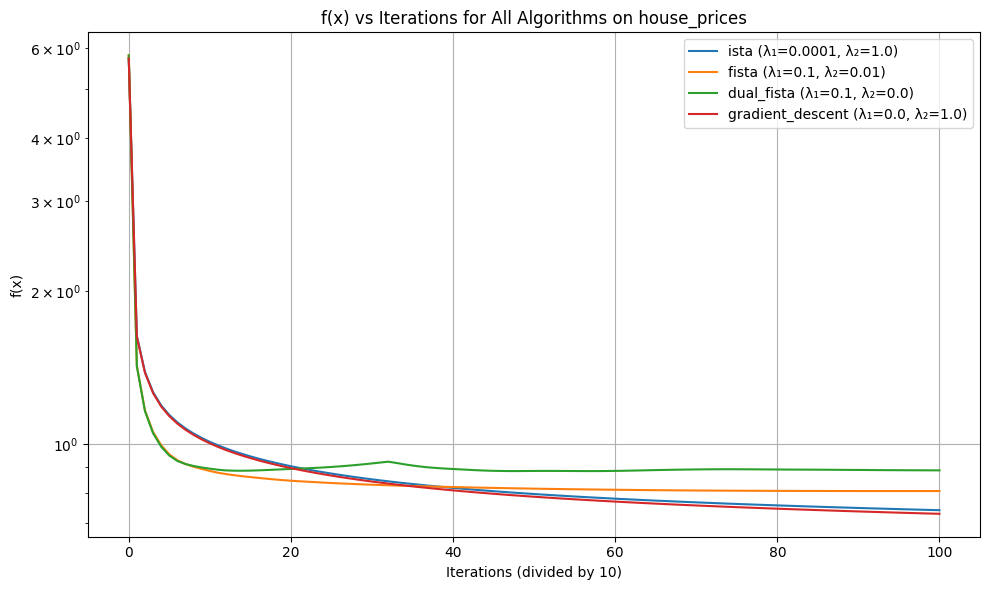

In [45]:
def plot_best_fx(records, best_params_df, dataset_name):
    """
    Plot MSE vs Iteration for all algorithms on the same dataset using their best hyperparameters.

    Parameters:
    - records: list of benchmark record dicts
    - best_params_df: DataFrame containing best parameters for each (algorithm, dataset)
    - dataset_name: name of the dataset to filter
    """
    plt.figure(figsize=(10, 6))
    found_any = False

    for _, row in best_params_df.iterrows():
        if row['dataset'] != dataset_name:
            continue

        algo = row['algorithm']
        l1 = row['lambda_l1']
        l2 = row['lambda_l2']

        for rec in records:
            if (rec['dataset'] == dataset_name and rec['algorithm'] == algo and
                rec['lambda_l1'] == l1 and rec['lambda_l2'] == l2):
                plt.plot(rec['f_x_history'], label=f"{algo} (λ₁={l1}, λ₂={l2})")
                found_any = True
                break

    if found_any:
        plt.title(f"f(x) vs Iterations for All Algorithms on {dataset_name}")
        plt.xlabel("Iterations (divided by 10)")
        plt.ylabel("f(x)")
        plt.yscale('log')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No records found for dataset: {dataset_name}")

plot_best_fx(combined_records, combined_best, "house_prices")

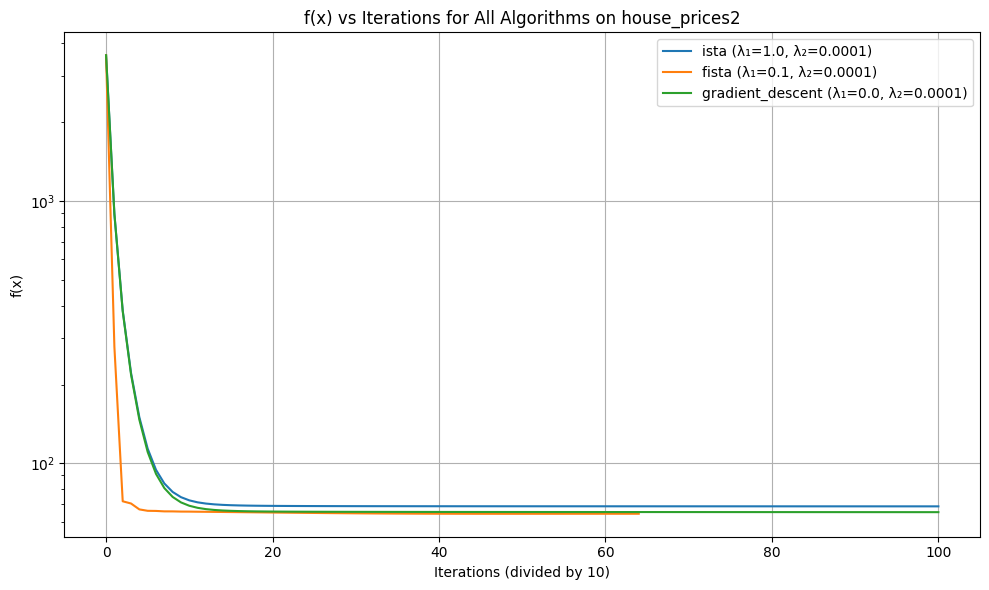

In [47]:
plot_best_fx(combined_records, combined_best, "house_prices2")

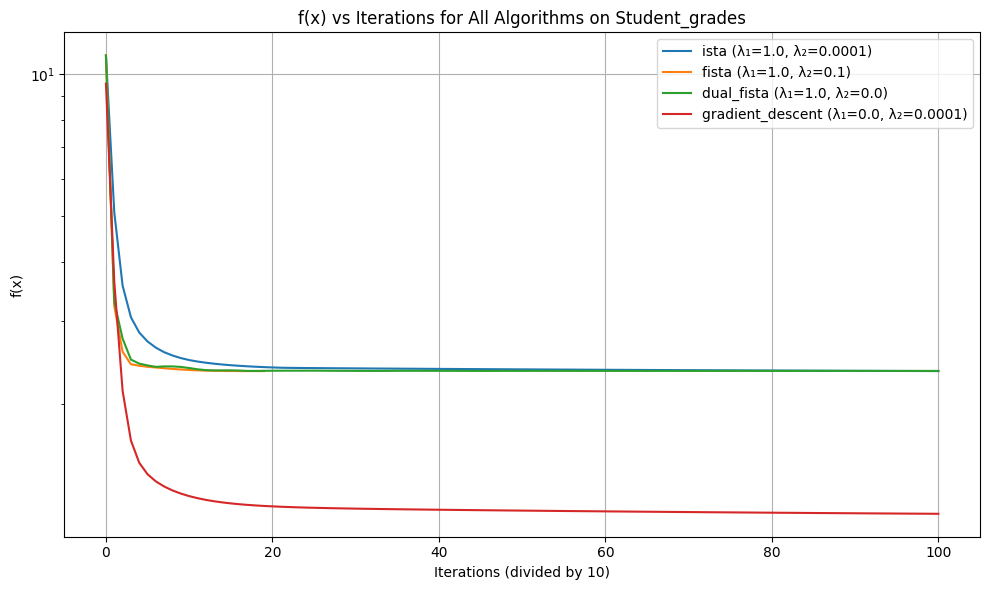

In [46]:
plot_best_fx(combined_records, combined_best, "Student_grades")

Creating representations of the different performance metrics of the best algorithms.

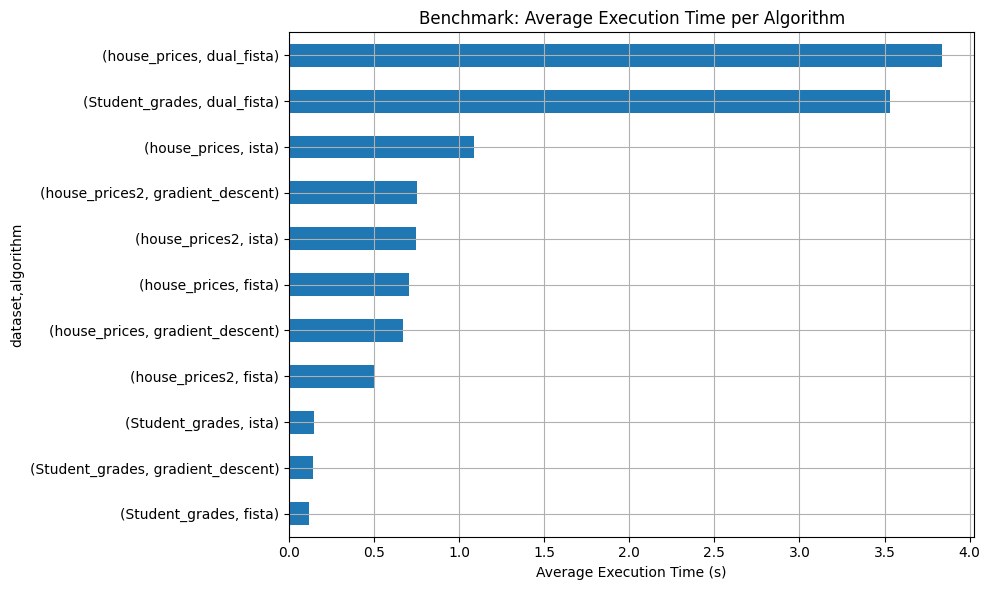

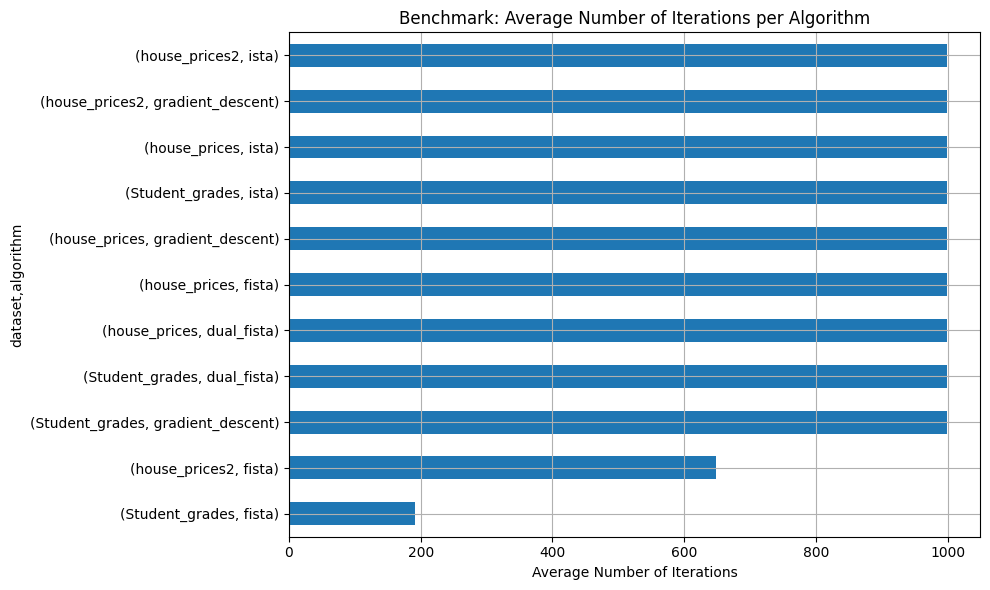

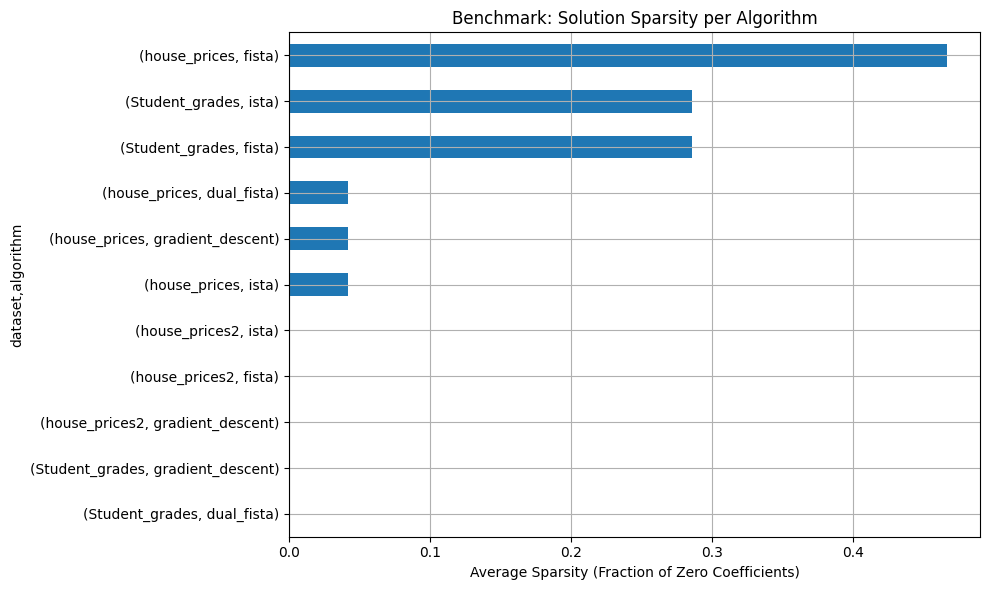

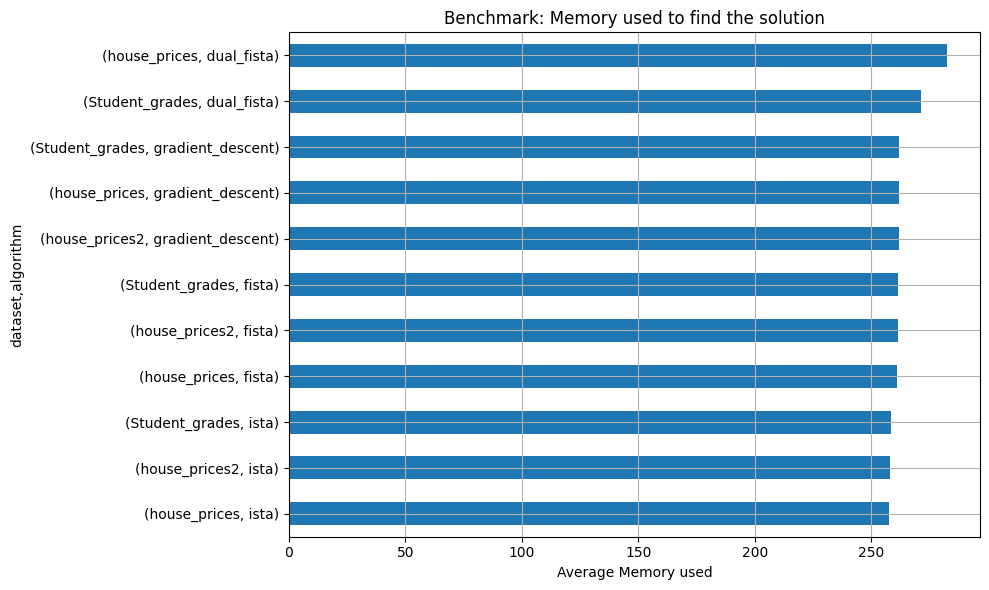

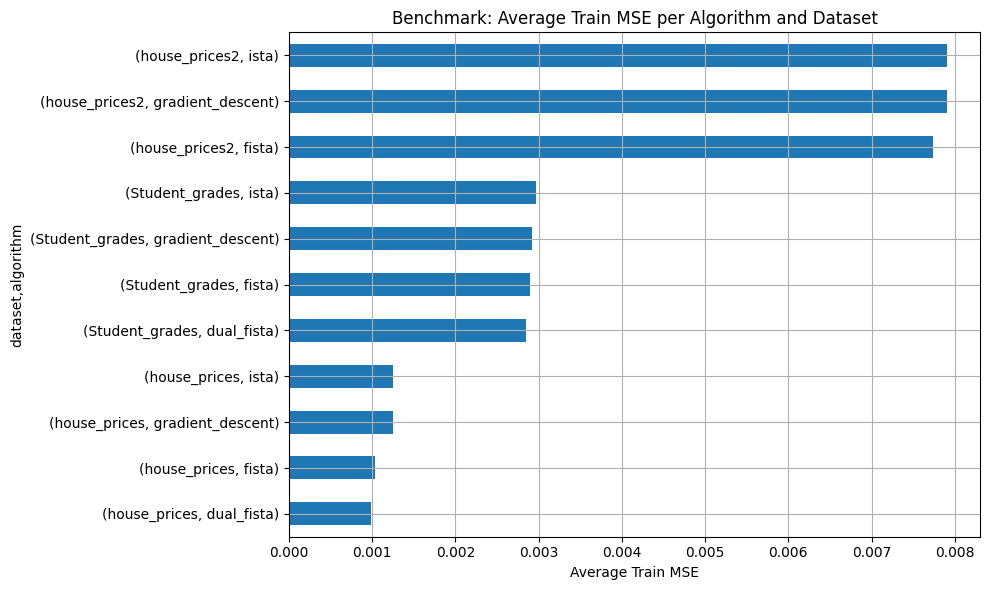

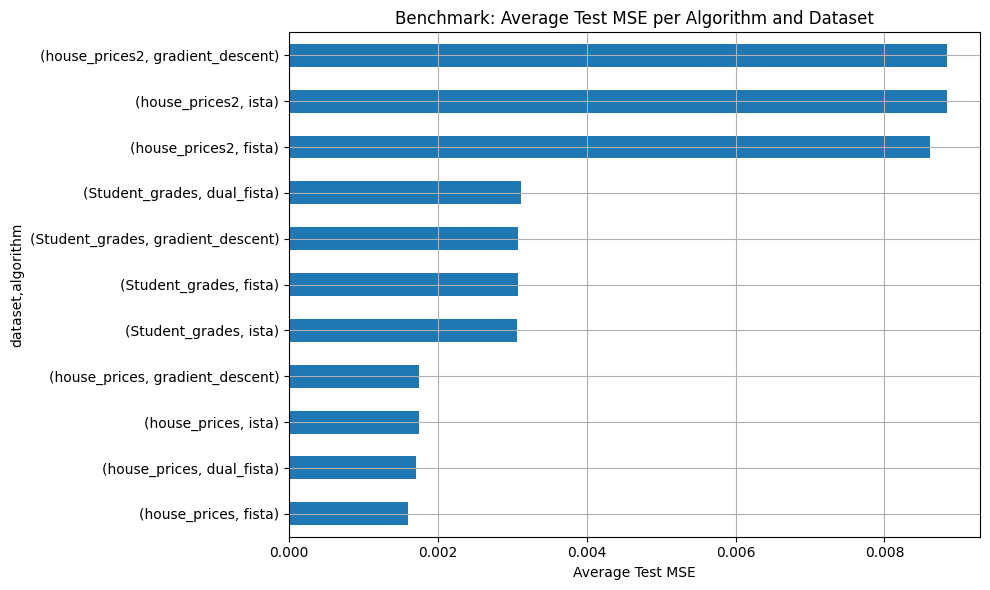

In [23]:
# Group by algorithm and compute mean execution time
avg_times = combined_best.groupby(['dataset','algorithm'])['avg_time'].mean().sort_values()

# Plotting
plt.figure(figsize=(10, 6))
avg_times.plot(kind='barh')
plt.xlabel('Average Execution Time (s)')
plt.title('Benchmark: Average Execution Time per Algorithm')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average Number of Iterations per Algorithm
avg_iterations = combined_best.groupby(['dataset','algorithm'])['avg_iterations'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_iterations.plot(kind='barh')
plt.xlabel('Average Number of Iterations')
plt.title('Benchmark: Average Number of Iterations per Algorithm')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average Sparsity per Algorithm
avg_sparsity = combined_best.groupby(['dataset','algorithm'])['solution_sparsity'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_sparsity.plot(kind='barh')
plt.xlabel('Average Sparsity (Fraction of Zero Coefficients)')
plt.title('Benchmark: Solution Sparsity per Algorithm')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average Memory per Algorithm
avg_sparsity = combined_best.groupby(['dataset','algorithm'])['avg_memory'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_sparsity.plot(kind='barh')
plt.xlabel('Average Memory used')
plt.title('Benchmark: Memory used to find the solution')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average MSE train
avg_mse_train = combined_best.groupby(['dataset', 'algorithm'])['mse_train'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_mse_train.plot(kind='barh')
plt.xlabel('Average Train MSE')
plt.title('Benchmark: Average Train MSE per Algorithm and Dataset')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average MSE test
avg_mse_test = combined_best.groupby(['dataset', 'algorithm'])['mse_test'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_mse_test.plot(kind='barh')
plt.xlabel('Average Test MSE')
plt.title('Benchmark: Average Test MSE per Algorithm and Dataset')
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
results_GD_back, records__GD_back = run_benchmark(
    algorithms=['gradient_descent'],
    data_configs=[],  # real datasets so empty
    lambda_range_l1=[0],
    lambda_range_l2=range_l2,
    real_datasets=real_datasets,
    target_cols=target_cols,
    max_iter=1000,
    tol=1e-5,
    return_iterations=True,
    line_search='backtracking',
    n_runs=1
)
best_params_GD_back = get_best_hyperparams(results_GD_back)
print(best_params_GD_back)

          dataset         algorithm  lambda_l1  lambda_l2  n_samples  \
0  Student_grades  gradient_descent          0      0.100        800   
1    house_prices  gradient_descent          0      0.100       1168   
2   house_prices2  gradient_descent          0      0.001      16512   

   n_features  sparsity   avg_time  std_time   min_time   max_time  \
0          14  0.000000   1.291714       0.0   1.291714   1.291714   
1         287  0.038328  30.545671       0.0  30.545671  30.545671   
2          13  0.000000  40.383250       0.0  40.383250  40.383250   

   max_iterations  min_iterations  avg_iterations  std_iterations  avg_memory  \
0             693             693           693.0             0.0  310.093750   
1            1999            1999          1999.0             0.0  309.710938   
2            1999            1999          1999.0             0.0  309.777344   

   mse_train  mse_test  solution_sparsity  error_to_true  
0   0.002876  0.003077           0.000000     

Quick test of backtracking on gradient descent, we can see that it makes the computing time explode with a very small improvement of the MSE. We multiply computing time by 30 and get an improvement of about 50% for this reason we will not be using backtracking for gradient descent.

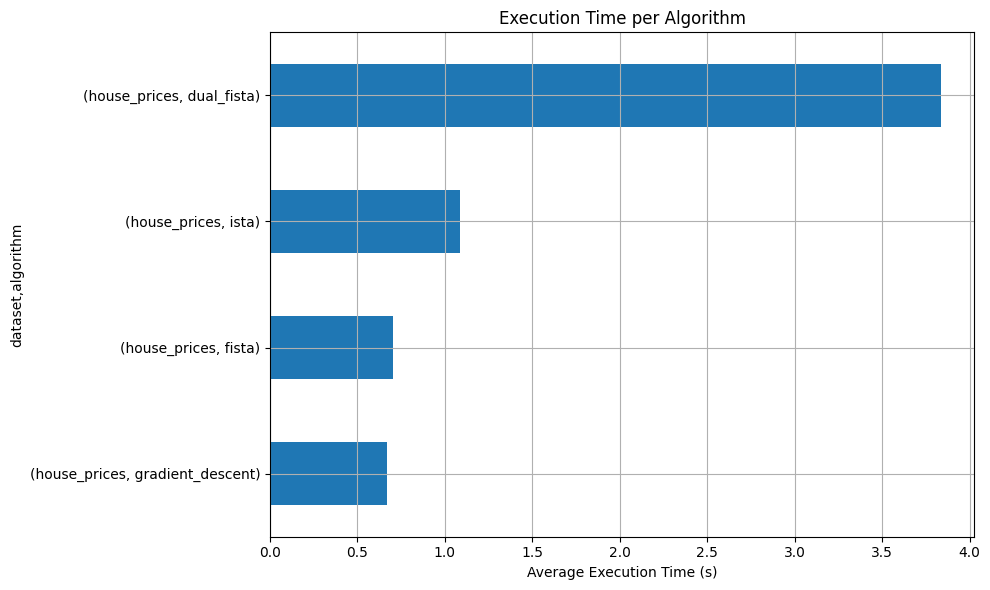

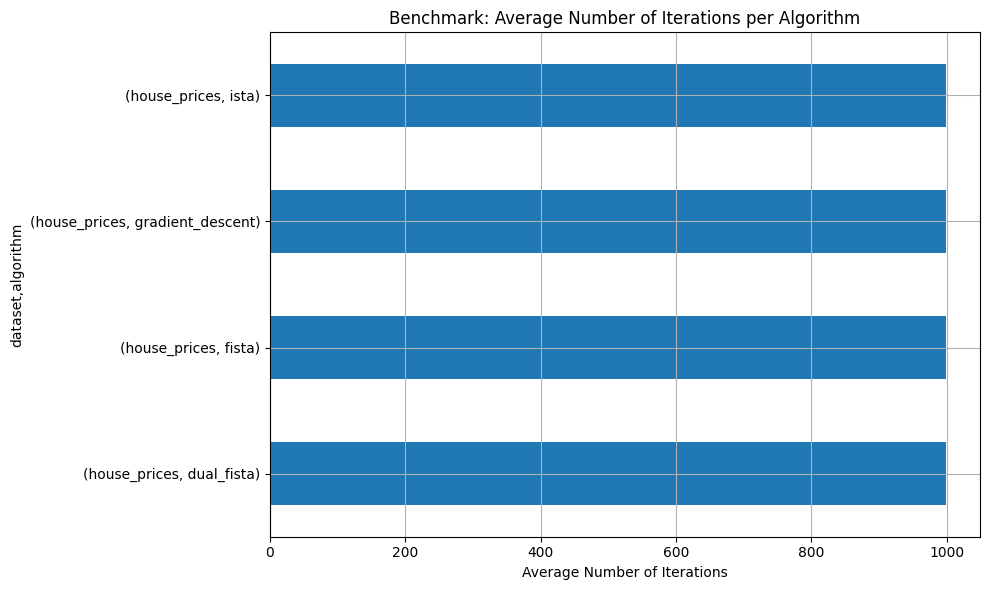

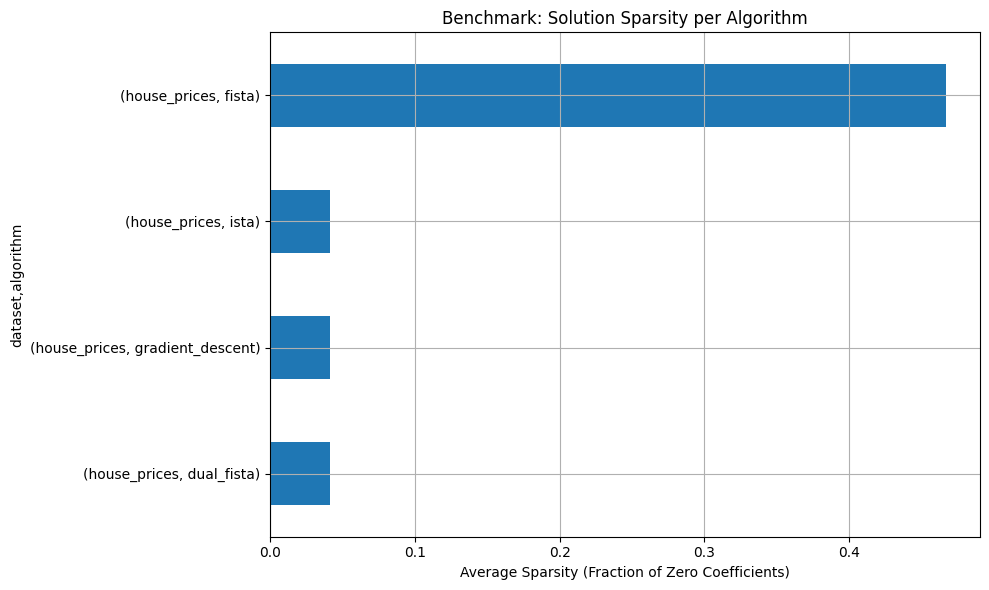

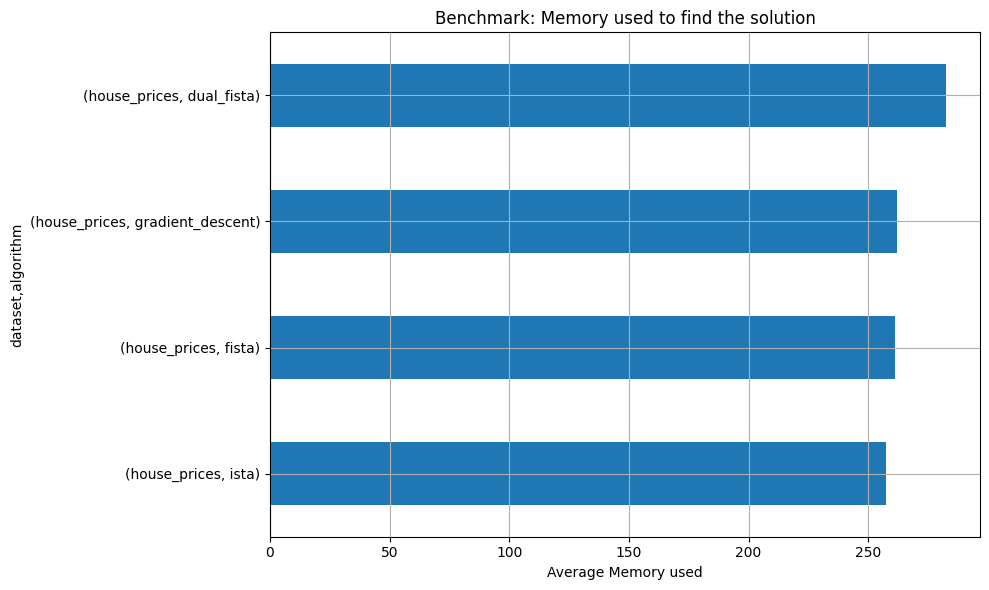

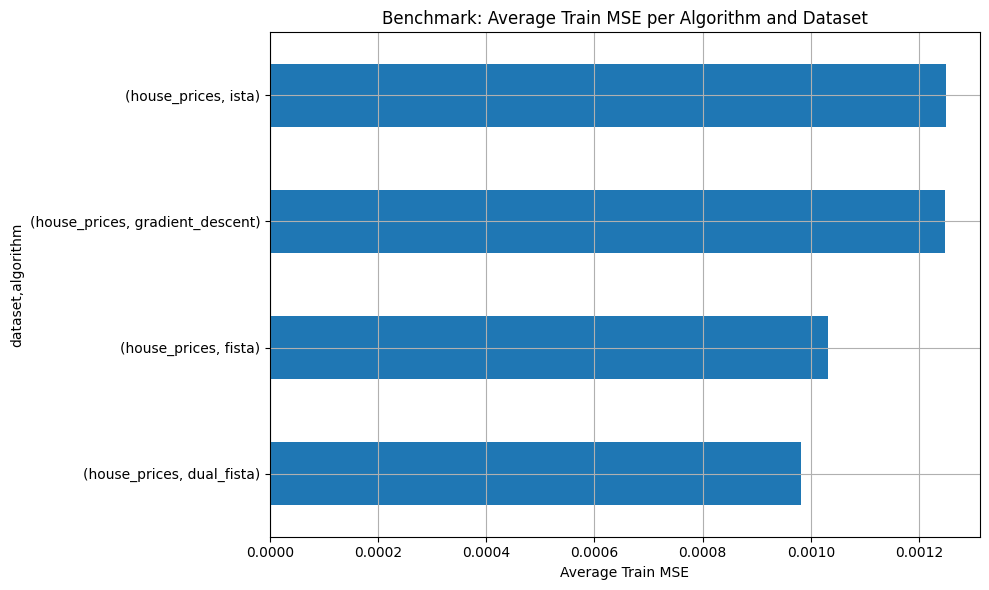

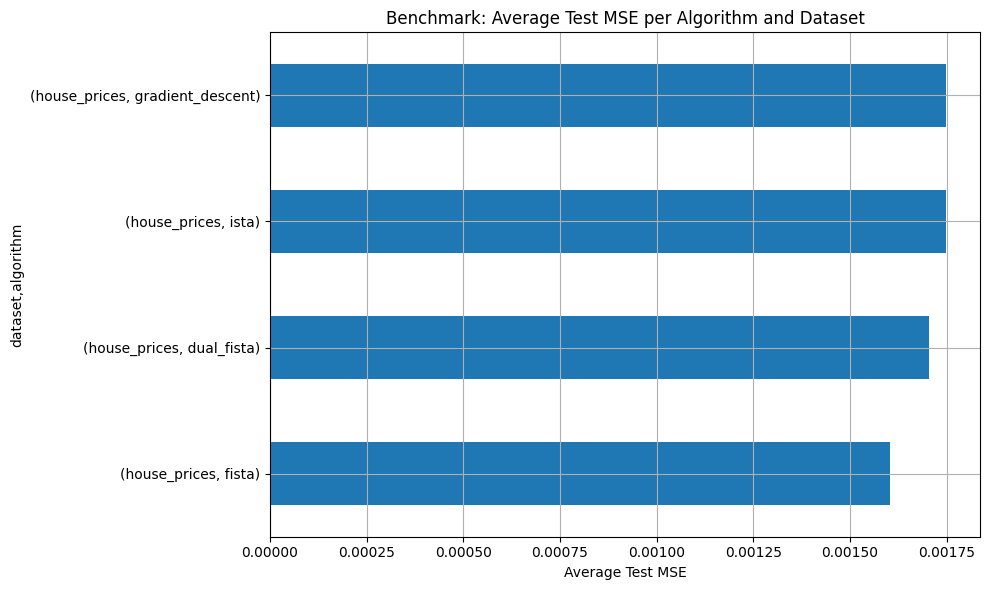

In [48]:
# Filter for a specific dataset
dataset_name = "house_prices"
df_subset = combined_best[combined_best['dataset'] == dataset_name]

# Group by algorithm only, and compute mean execution time
avg_times = df_subset.groupby(['dataset','algorithm'])['avg_time'].mean().sort_values()

# Plotting
plt.figure(figsize=(10, 6))
avg_times.plot(kind='barh')
plt.xlabel('Average Execution Time (s)')
plt.title('Execution Time per Algorithm')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average Number of Iterations per Algorithm
avg_iterations = df_subset.groupby(['dataset','algorithm'])['avg_iterations'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_iterations.plot(kind='barh')
plt.xlabel('Average Number of Iterations')
plt.title('Benchmark: Average Number of Iterations per Algorithm')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average Sparsity per Algorithm
avg_sparsity = df_subset.groupby(['dataset','algorithm'])['solution_sparsity'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_sparsity.plot(kind='barh')
plt.xlabel('Average Sparsity (Fraction of Zero Coefficients)')
plt.title('Benchmark: Solution Sparsity per Algorithm')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average Memory per Algorithm
avg_sparsity = df_subset.groupby(['dataset','algorithm'])['avg_memory'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_sparsity.plot(kind='barh')
plt.xlabel('Average Memory used')
plt.title('Benchmark: Memory used to find the solution')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average MSE train
avg_mse_train = df_subset.groupby(['dataset', 'algorithm'])['mse_train'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_mse_train.plot(kind='barh')
plt.xlabel('Average Train MSE')
plt.title('Benchmark: Average Train MSE per Algorithm and Dataset')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average MSE test
avg_mse_test = df_subset.groupby(['dataset', 'algorithm'])['mse_test'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_mse_test.plot(kind='barh')
plt.xlabel('Average Test MSE')
plt.title('Benchmark: Average Test MSE per Algorithm and Dataset')
plt.grid(True)
plt.tight_layout()
plt.show()

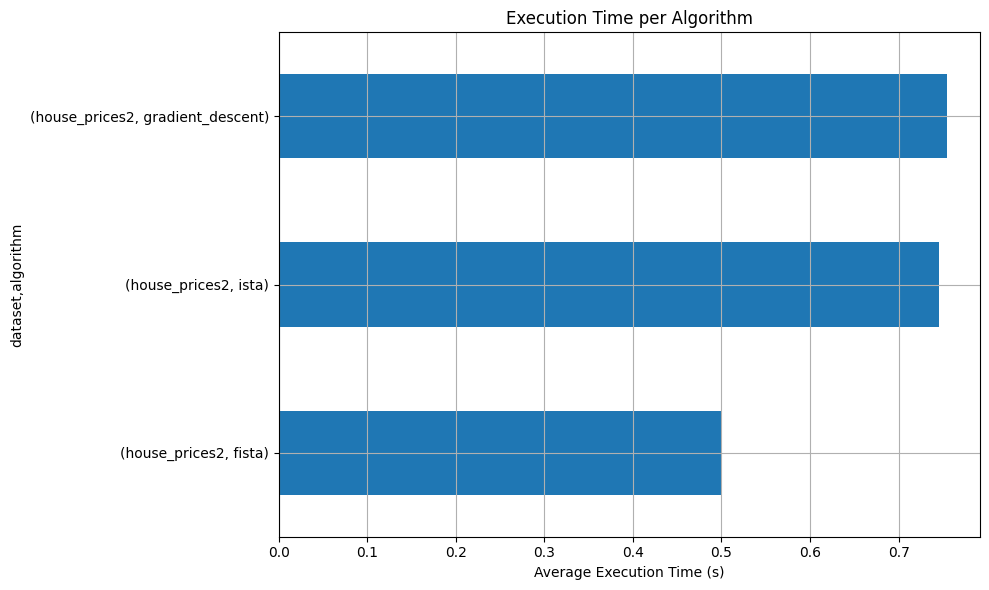

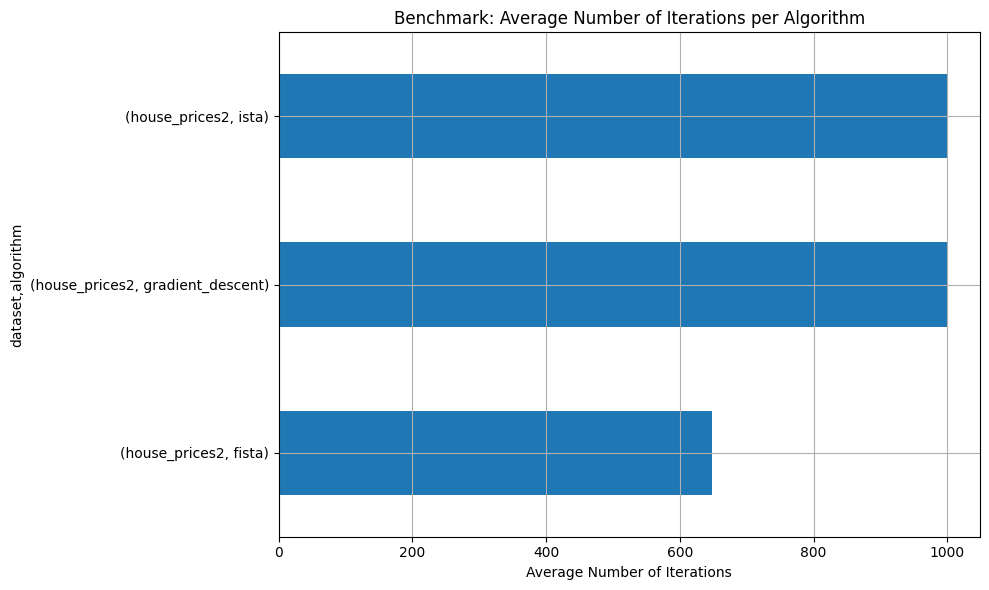

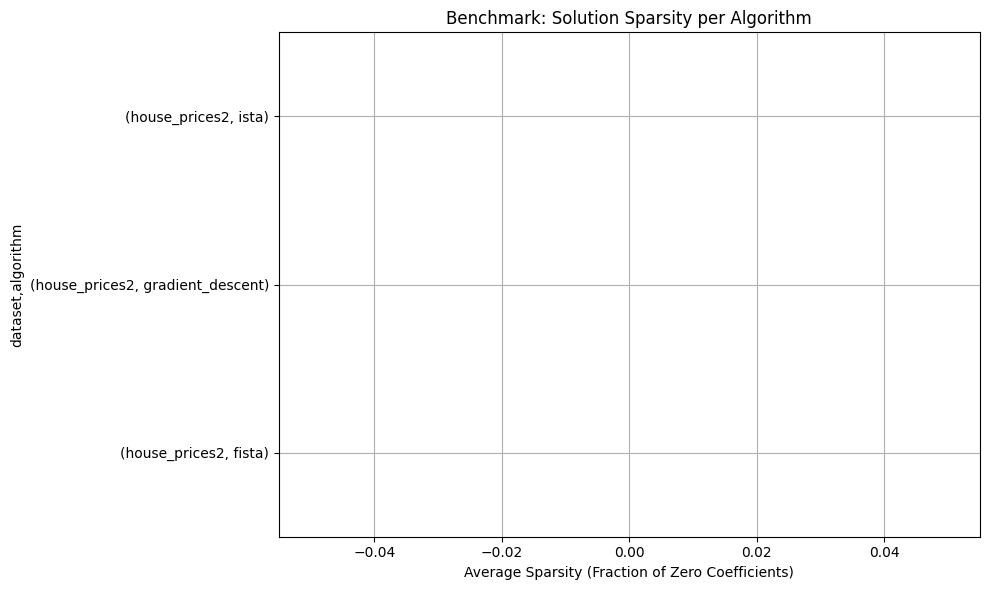

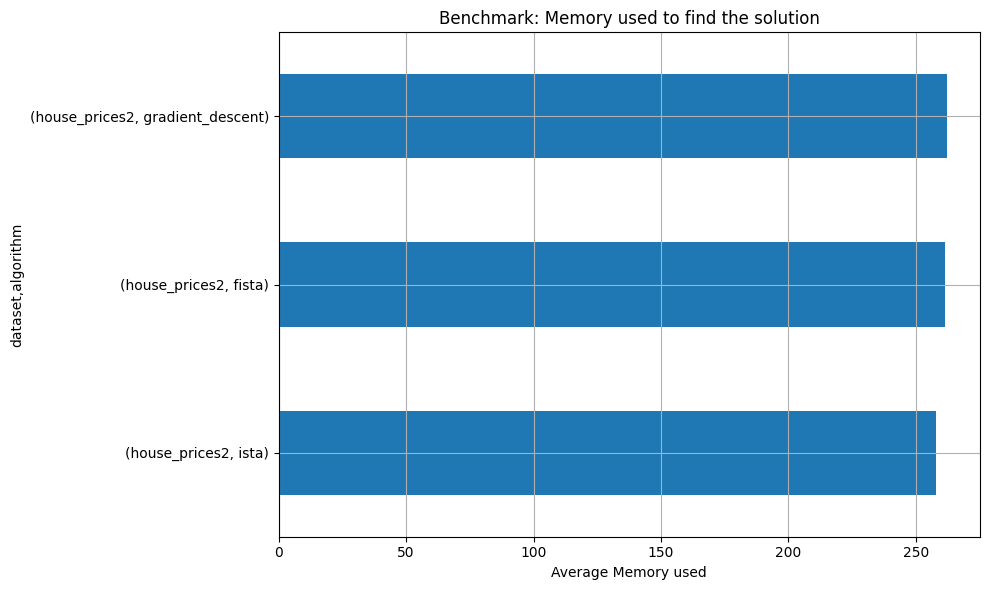

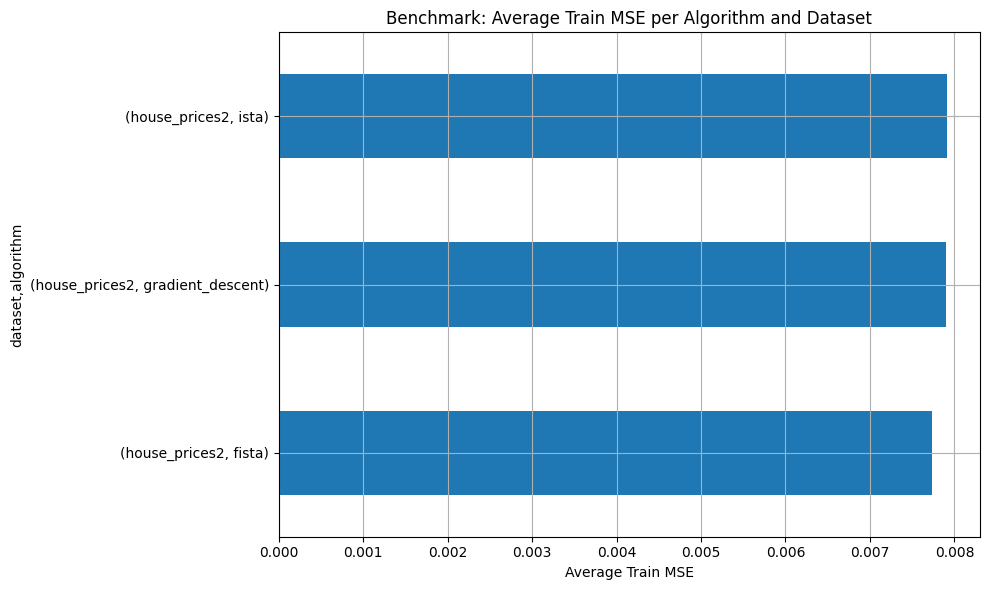

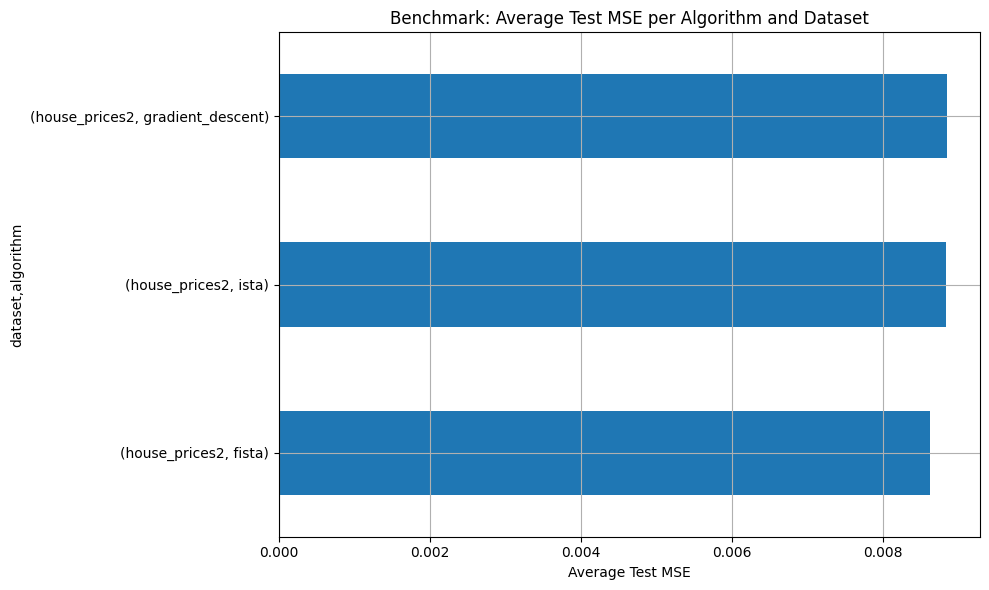

In [49]:
# Filter for a specific dataset
dataset_name = "house_prices2"
df_subset = combined_best[combined_best['dataset'] == dataset_name]

# Group by algorithm only, and compute mean execution time
avg_times = df_subset.groupby(['dataset','algorithm'])['avg_time'].mean().sort_values()

# Plotting
plt.figure(figsize=(10, 6))
avg_times.plot(kind='barh')
plt.xlabel('Average Execution Time (s)')
plt.title('Execution Time per Algorithm')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average Number of Iterations per Algorithm
avg_iterations = df_subset.groupby(['dataset','algorithm'])['avg_iterations'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_iterations.plot(kind='barh')
plt.xlabel('Average Number of Iterations')
plt.title('Benchmark: Average Number of Iterations per Algorithm')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average Sparsity per Algorithm
avg_sparsity = df_subset.groupby(['dataset','algorithm'])['solution_sparsity'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_sparsity.plot(kind='barh')
plt.xlabel('Average Sparsity (Fraction of Zero Coefficients)')
plt.title('Benchmark: Solution Sparsity per Algorithm')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average Memory per Algorithm
avg_sparsity = df_subset.groupby(['dataset','algorithm'])['avg_memory'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_sparsity.plot(kind='barh')
plt.xlabel('Average Memory used')
plt.title('Benchmark: Memory used to find the solution')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average MSE train
avg_mse_train = df_subset.groupby(['dataset', 'algorithm'])['mse_train'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_mse_train.plot(kind='barh')
plt.xlabel('Average Train MSE')
plt.title('Benchmark: Average Train MSE per Algorithm and Dataset')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average MSE test
avg_mse_test = df_subset.groupby(['dataset', 'algorithm'])['mse_test'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_mse_test.plot(kind='barh')
plt.xlabel('Average Test MSE')
plt.title('Benchmark: Average Test MSE per Algorithm and Dataset')
plt.grid(True)
plt.tight_layout()
plt.show()

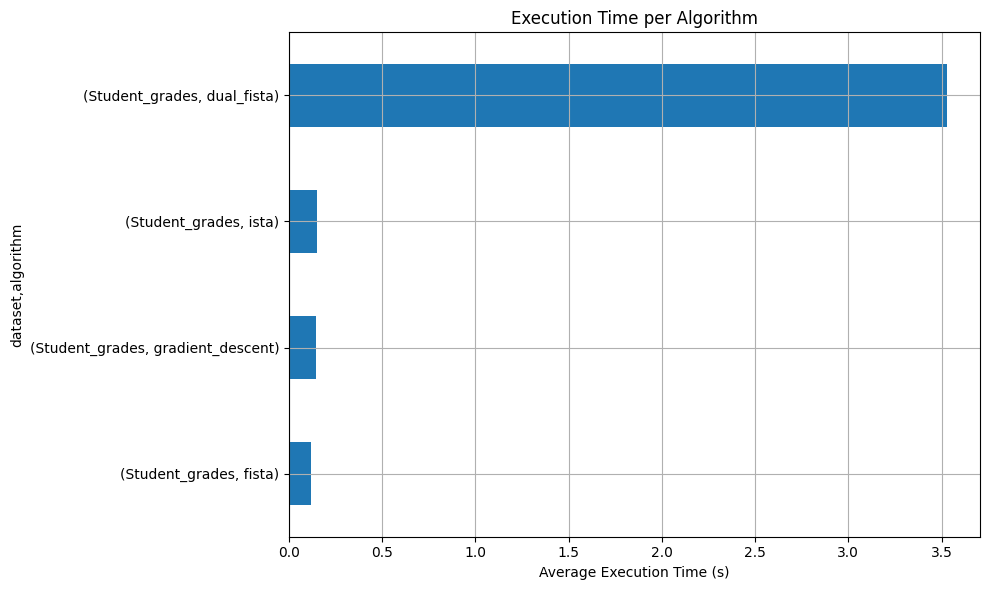

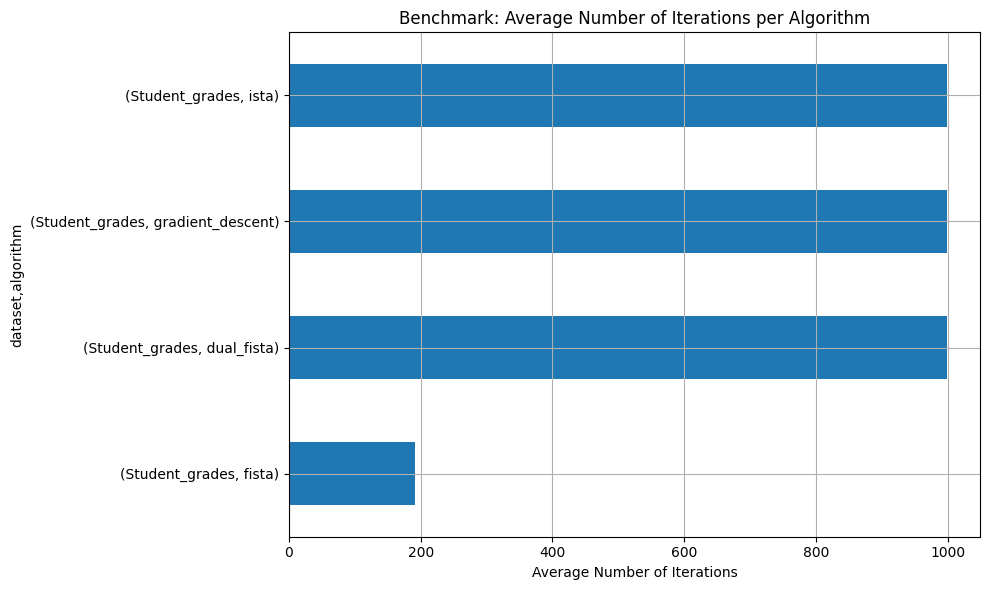

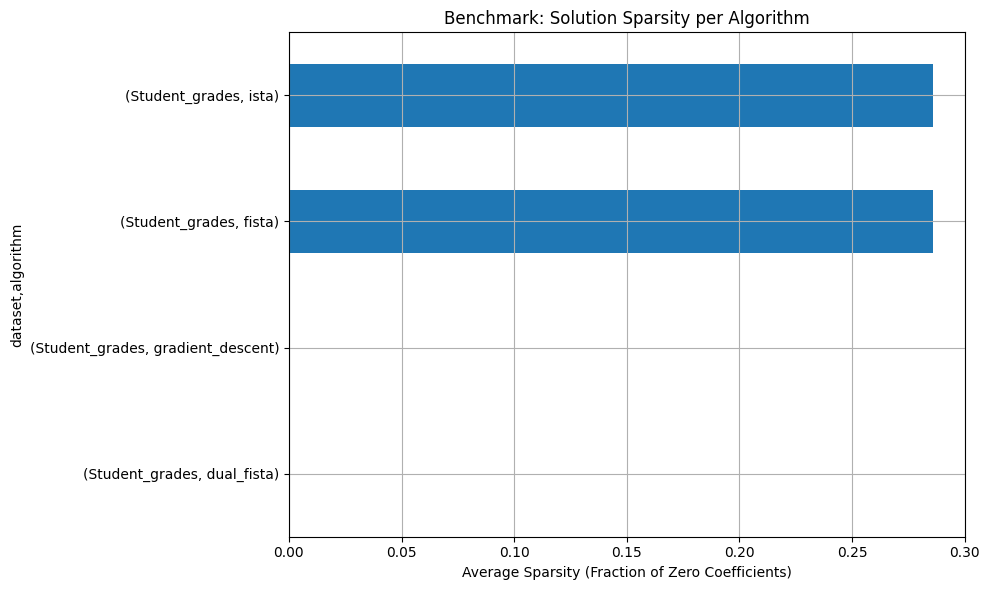

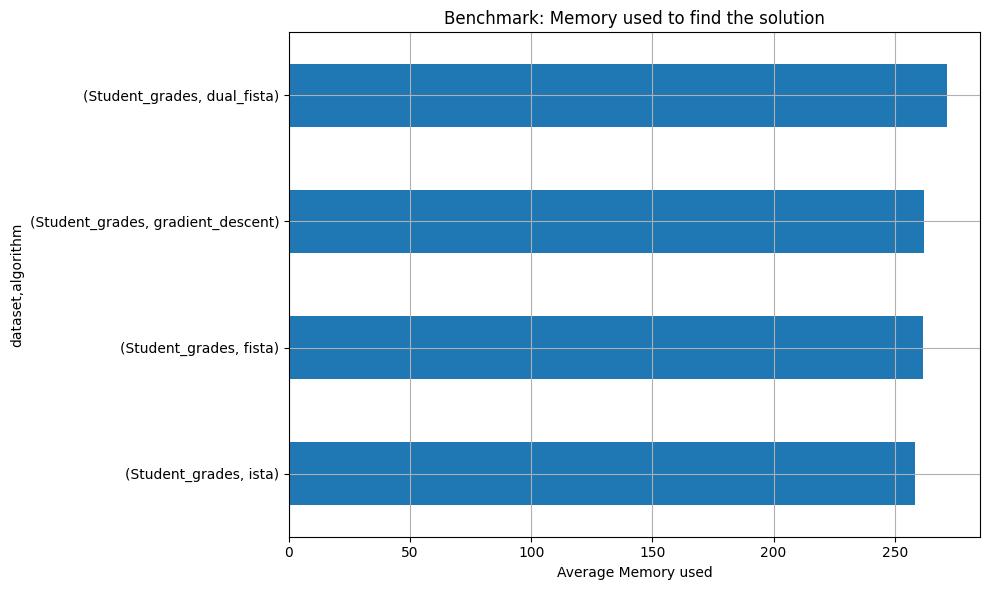

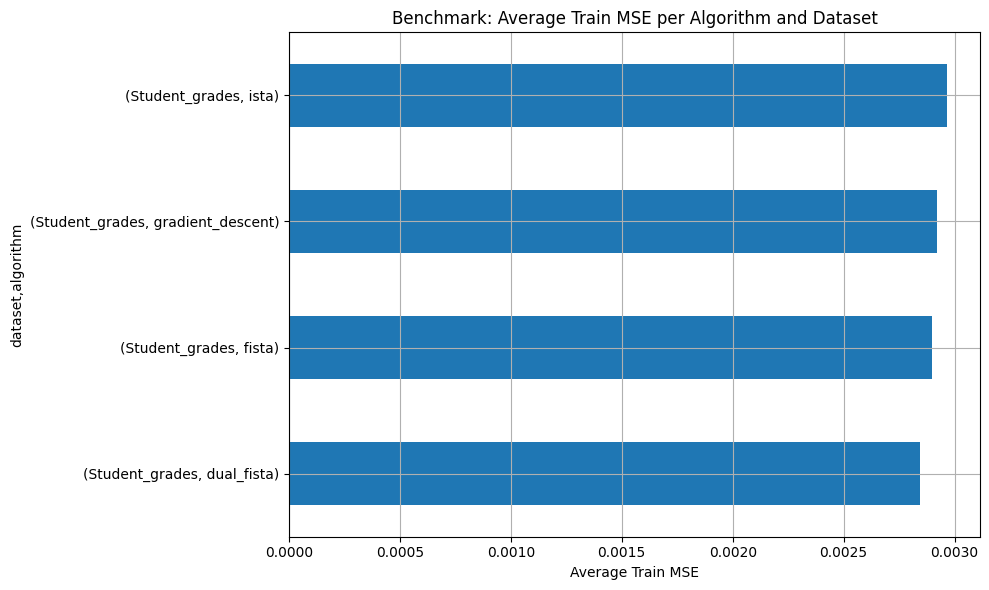

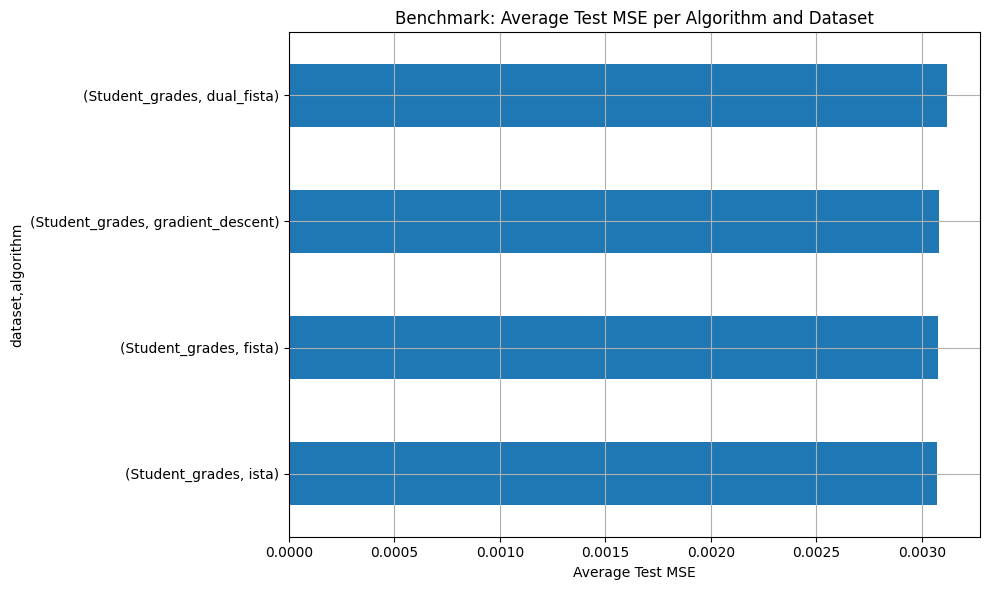

In [50]:
# Filter for a specific dataset
dataset_name = "Student_grades"
df_subset = combined_best[combined_best['dataset'] == dataset_name]

# Group by algorithm only, and compute mean execution time
avg_times = df_subset.groupby(['dataset','algorithm'])['avg_time'].mean().sort_values()

# Plotting
plt.figure(figsize=(10, 6))
avg_times.plot(kind='barh')
plt.xlabel('Average Execution Time (s)')
plt.title('Execution Time per Algorithm')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average Number of Iterations per Algorithm
avg_iterations = df_subset.groupby(['dataset','algorithm'])['avg_iterations'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_iterations.plot(kind='barh')
plt.xlabel('Average Number of Iterations')
plt.title('Benchmark: Average Number of Iterations per Algorithm')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average Sparsity per Algorithm
avg_sparsity = df_subset.groupby(['dataset','algorithm'])['solution_sparsity'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_sparsity.plot(kind='barh')
plt.xlabel('Average Sparsity (Fraction of Zero Coefficients)')
plt.title('Benchmark: Solution Sparsity per Algorithm')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average Memory per Algorithm
avg_sparsity = df_subset.groupby(['dataset','algorithm'])['avg_memory'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_sparsity.plot(kind='barh')
plt.xlabel('Average Memory used')
plt.title('Benchmark: Memory used to find the solution')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average MSE train
avg_mse_train = df_subset.groupby(['dataset', 'algorithm'])['mse_train'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_mse_train.plot(kind='barh')
plt.xlabel('Average Train MSE')
plt.title('Benchmark: Average Train MSE per Algorithm and Dataset')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot: Average MSE test
avg_mse_test = df_subset.groupby(['dataset', 'algorithm'])['mse_test'].mean().sort_values()

plt.figure(figsize=(10, 6))
avg_mse_test.plot(kind='barh')
plt.xlabel('Average Test MSE')
plt.title('Benchmark: Average Test MSE per Algorithm and Dataset')
plt.grid(True)
plt.tight_layout()
plt.show()